# Insertion Only streams

## Connectivity Trees and Spanners

In [3]:
import numpy as np

class UnionFind:
    def __init__(self,n):
        self.parent = np.arange(n)
        self.rank = np.zeros(n)
    
    def find(self,u):
        if self.parent[u] != u:
            self.parent[u] = self.find(self.parent[u])
        return self.parent[u]
    
    def union(self,u,v):
        rootu = self.find(u)
        rootv = self.find(v)

        if rootu == rootv:
            return False
        
        if self.rank[rootu] < self.rank[rootv]:
            self.parent[rootu] = rootv
        elif self.rank[rootu] > self.rank[rootv]:
            self.parent[rootv] = rootu
        else:
            self.parent[rootv] = rootu
            self.rank[rootu]+=1

        return True
    

def spanning_forest(n, edge_stream):
    """
    Constructs a spanning forest for a graph with n vertices given an edge stream.
    
    Parameters:
      n           : number of vertices
      edge_stream : iterable of (u, v) tuples representing edges
      
    Returns:
      spanning_edges : list of edges that are in the spanning forest.
    """
    uf = UnionFind(n)
    spanning_edges = []
    for u, v in edge_stream:
        # If there's no path between u and v, union returns True and we add the edge.
        if uf.union(u, v):
            spanning_edges.append((u, v))
    return spanning_edges

def is_connected(n, edge_stream):
    """
    Determines if the graph is connected using the spanning forest algorithm.
    
    Returns True if the graph is connected (i.e., one spanning tree covers all vertices),
    or False otherwise.
    """
    spanning_edges = spanning_forest(n, edge_stream)
    # Rebuild the union-find structure based on the spanning forest.
    uf = UnionFind(n)
    for u, v in spanning_edges:
        uf.union(u, v)
    # A graph is connected if all vertices share the same root.
    roots = {uf.find(i) for i in range(n)}
    return len(roots) == 1



In [4]:
from collections import deque

def bfs_distance(H, start, target, max_depth):
    """
    Performs a BFS in H (an adjacency list) starting at 'start'
    and looks for 'target' up to a maximum depth of max_depth.
    Returns the distance if target is found within max_depth steps;
    otherwise returns infinity.
    """
    if start == target:
        return 0
    visited = {start}
    queue = deque([(start, 0)])
    while queue:
        node, depth = queue.popleft()
        if depth < max_depth:
            for neighbor in H.get(node, []):
                if neighbor == target:
                    return depth + 1
                if neighbor not in visited:
                    visited.add(neighbor)
                    queue.append((neighbor, depth + 1))
    return float('inf')

def spanner(n, edge_stream, stretch):
    """
    Constructs a spanner H for an unweighted graph on n vertices.
    
    Parameters:
      n           : Number of vertices (assumed to be 0, 1, ..., n-1).
      edge_stream : Iterable of edges (u, v) representing the input stream.
      stretch     : The threshold for the distance in H. For a (2t+1)-spanner, set stretch = 2t+1.
      
    Returns:
      spanner_edges : List of edges in the spanner H.
    """
    # Initialize the spanner H as an empty graph (adjacency list).
    H = {i: [] for i in range(n)}
    spanner_edges = []
    
    for u, v in edge_stream:
        # Check the current distance between u and v in H (up to the given stretch).
        d = bfs_distance(H, u, v, stretch)
        # If the current path is longer than the allowed threshold, add the edge.
        if d > stretch:
            H[u].append(v)
            H[v].append(u)
            spanner_edges.append((u, v))
    
    return spanner_edges

In [5]:
# Link–Cut Tree implementation supporting maximum-edge queries.
# Each vertex is represented by a Node.
# The attribute 'edge_weight' holds the weight of the edge from this node to its parent.
# For a root, edge_weight is set to -infinity.
# The field max_value stores the maximum weight in the (splay) subtree,
# and max_edge points to the node whose associated edge is maximum.

class Node:
    def __init__(self, id):
        self.id = id
        self.left = None
        self.right = None
        self.parent = None
        self.rev = False  # For lazy propagation of reversals.
        self.edge_weight = float('-inf')  # Weight on edge from parent to this node.
        self.max_value = self.edge_weight  # Maximum weight in the subtree.
        self.max_edge = self  # Node with maximum edge weight in subtree.

def is_root(x):
    return x.parent is None or (x.parent.left != x and x.parent.right != x)

def push(x):
    if x.rev:
        x.left, x.right = x.right, x.left
        if x.left:
            x.left.rev ^= True
        if x.right:
            x.right.rev ^= True
        x.rev = False

def update(x):
    # Recompute the max_value and max_edge from x and its children.
    x.max_value = x.edge_weight
    x.max_edge = x  # Candidate: itself.
    if x.left:
        if x.left.max_value > x.max_value:
            x.max_value = x.left.max_value
            x.max_edge = x.left.max_edge
    if x.right:
        if x.right.max_value > x.max_value:
            x.max_value = x.right.max_value
            x.max_edge = x.right.max_edge

def rotate(x):
    p = x.parent
    g = p.parent
    if not is_root(p):
        if g.left == p:
            g.left = x
        else:
            g.right = x
    x.parent = g
    if p.left == x:
        p.left = x.right
        if x.right:
            x.right.parent = p
        x.right = p
        p.parent = x
    else:
        p.right = x.left
        if x.left:
            x.left.parent = p
        x.left = p
        p.parent = x
    update(p)
    update(x)

def splay(x):
    # Bring x to the root of its splay tree.
    stack = []
    y = x
    while not is_root(y):
        stack.append(y)
        y = y.parent
    stack.append(y)
    while stack:
        push(stack.pop())
    while not is_root(x):
        p = x.parent
        g = p.parent
        if not is_root(p):
            if (g.left == p) == (p.left == x):
                rotate(p)
            else:
                rotate(x)
        rotate(x)

def access(x):
    # Makes x the rightmost node in its preferred path,
    # thereby exposing the tree path from the root to x.
    last = None
    y = x
    while y:
        splay(y)
        y.right = last
        update(y)
        last = y
        y = y.parent
    splay(x)

def make_root(x):
    access(x)
    x.rev ^= True
    push(x)

def find_root(x):
    access(x)
    while x.left:
        push(x)
        x = x.left
    splay(x)
    return x

def link(x, y, weight):
    # Add edge (x, y) with given weight.
    # Precondition: x and y must be in different trees.
    make_root(x)
    # Now, x becomes a root; set its parent to y.
    x.parent = y
    x.edge_weight = weight
    update(x)

def cut(x, y):
    # Remove the edge between x and y.
    make_root(x)
    access(y)
    # After access, y.left should be x if (x,y) is an edge.
    if y.left != x:
        return  # Edge does not exist.
    y.left.parent = None
    y.left = None
    update(y)

def query(x, y):
    # Returns (max_edge_weight, node) on the path from x to y.
    make_root(x)
    access(y)
    return y.max_value, y.max_edge

# -------------------------------------------------------------------------
# Now we use the link–cut tree to maintain a dynamic MST.
#
# For each new edge (u, v, w) from the stream:
#   1. If u and v are in different trees (i.e. disconnected), we add the edge.
#   2. If they are already connected, then adding (u,v) creates a cycle.
#      We query for the maximum weighted edge on the path from u to v.
#      If that maximum is larger than w, we remove that heavy edge and add (u,v).
#      Otherwise, we discard (u,v).

def process_edge_stream(n, edge_stream):
    # Create one link–cut tree node for each vertex.
    nodes = [Node(i) for i in range(n)]
    # We keep a list of edges currently in the MST.
    mst_edges = []
    
    for u, v, w in edge_stream:
        # If u and v are not connected, simply add the edge.
        if find_root(nodes[u]) != find_root(nodes[v]):
            link(nodes[u], nodes[v], w)
            mst_edges.append((u, v, w))
        else:
            # They are connected; a cycle is formed by adding (u, v).
            # Query the maximum edge weight on the current u-v path.
            max_w, max_node = query(nodes[u], nodes[v])
            if max_w > w:
                # Remove the heavy edge.
                # The heavy edge is associated with 'max_node' and its parent.
                heavy_u = max_node.id
                heavy_v = max_node.parent.id if max_node.parent else None
                # Remove the edge from the tree.
                cut(max_node, max_node.parent)
                # Optionally, remove (heavy_u, heavy_v, max_w) from mst_edges.
                # For simplicity, we append the new edge.
                link(nodes[u], nodes[v], w)
                mst_edges.append((u, v, w))
            # Else: if the maximum edge is no heavier than w, then (u,v) is discarded.
    return mst_edges

# -------------------------------------------------------------------------
# Example usage:
if __name__ == "__main__":
    # Example edge stream as a list of tuples: (u, v, weight)
    edges = [
        (0, 1, 4),
        (1, 2, 3),
        (0, 2, 5),
        (2, 3, 2),
        (3, 4, 1),
        (1, 4, 6)
    ]
    n = 5  # Number of vertices
    mst = process_edge_stream(n, edges)
    print("MST edges:", mst)


MST edges: [(0, 1, 4), (1, 2, 3), (2, 3, 2), (3, 4, 1)]


# Graph Sparsification

# Another attempt

In [6]:
!pip install pandas

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx

G = nx.read_edgelist('./dataset/twitch/DE/musae_DE_edges.csv', delimiter=',', nodetype=int, data=(('weight', float),))
G = nx.Graph(G)

In [8]:
print(G)

Graph with 9498 nodes and 153138 edges


### MST,COnnectivity,Spanners,Greedy mathcing,Greedy Weighted Matching

In [9]:
import networkx as nx
import time
import tracemalloc
import random
import sys
import matplotlib.pyplot as plt
from collections import defaultdict
import math

def create_sample_graph(n=100, p=0.1, seed=42, weighted=True):
    """Creates a sample Erdős-Rényi graph."""
    print(f"Creating sample graph G (n={n}, p={p})...")
    G_sample = nx.erdos_renyi_graph(n, p, seed=seed, directed=False)
    # Ensure graph is connected (or mostly connected for sparse graphs)
    # Add edges to connect components if needed
    if not nx.is_connected(G_sample):
        components = list(nx.connected_components(G_sample))
        if len(components) > 1:
            print(f"Graph is not connected ({len(components)} components). Adding edges...")
            for i in range(len(components) - 1):
                u = random.choice(list(components[i]))
                v = random.choice(list(components[i+1]))
                if not G_sample.has_edge(u,v):
                    G_sample.add_edge(u, v)

    if weighted:
        random.seed(seed)
        for u, v in G_sample.edges():
            G_sample[u][v]['weight'] = random.uniform(1.0, 10.0)
        print("Added random weights to edges.")
    else:
         for u, v in G_sample.edges():
            G_sample[u][v]['weight'] = 1 # Default weight for unweighted cases if needed

    # Ensure nodes are 0 to n-1 if erdos_renyi_graph doesn't guarantee it
    nodes = list(G_sample.nodes())
    if set(nodes) != set(range(n)):
        mapping = {old_node: i for i, old_node in enumerate(nodes)}
        G_sample = nx.relabel_nodes(G_sample, mapping)
        print("Relabeled nodes to be 0 to n-1.")

    print(f"Sample graph created with {G_sample.number_of_nodes()} nodes and {G_sample.number_of_edges()} edges.")
    return G_sample


class UnionFind:
    """Simple Union-Find implementation."""
    def __init__(self, n):
        self.parent = list(range(n))
        self.rank = [0] * n
        self.num_nodes = n

    def find(self, i):
        if self.parent[i] == i:
            return i
        self.parent[i] = self.find(self.parent[i])  # Path compression
        return self.parent[i]

    def union(self, i, j):
        root_i = self.find(i)
        root_j = self.find(j)
        if root_i != root_j:
            # Union by rank
            if self.rank[root_i] < self.rank[root_j]:
                self.parent[root_i] = root_j
            elif self.rank[root_i] > self.rank[root_j]:
                self.parent[root_j] = root_i
            else:
                self.parent[root_j] = root_i
                self.rank[root_i] += 1
            return True
        return False


def measure_memory(func, *args, **kwargs):
    """Measures peak memory usage of a function call using tracemalloc."""
    tracemalloc.start()
    start_time = time.time()
    result = func(*args, **kwargs)
    end_time = time.time()
    current, peak = tracemalloc.get_traced_memory()
    tracemalloc.stop()
    elapsed_time = end_time - start_time
    # Peak memory is more indicative of the algorithm's space requirement
    return result, elapsed_time, peak


# 1. Connectivity (Spanning Forest using Union-Find)
def run_connectivity(stream, n):
    """
    Constructs a spanning forest using Union-Find.
    Space: O(n) for UF + O(n) for edges = O(n)
    Time per edge: O(alpha(n)) for UF operations (alpha is inverse Ackermann, nearly constant)
    Total Time: O(m * alpha(n))
    """
    uf = UnionFind(n)
    spanning_forest_edges = []
    nodes_seen = set()

    for u, v, _ in stream: # Ignore weight for connectivity
        nodes_seen.add(u)
        nodes_seen.add(v)
        # Ensure UF is initialized for nodes up to max(u, v) if n wasn't exact
        # This check is less critical if n >= max node id in stream
        if max(u, v) >= uf.num_nodes:
             # This scenario shouldn't happen if n is correctly the max node id + 1
             print(f"Warning: Edge ({u},{v}) exceeds initial n={uf.num_nodes}. This indicates an issue.")
             continue # Skip edge or resize UF (resizing is complex here)

        if uf.union(u, v):
            spanning_forest_edges.append(tuple(sorted((u, v))))

    # Create the resulting graph object (optional, for analysis)
    H = nx.Graph()
    H.add_nodes_from(range(n)) # Add all potential nodes
    H.add_edges_from(spanning_forest_edges)
    return H, len(spanning_forest_edges) # Return graph and edge count

# 2. Spanner Construction (Algorithm 1)
def run_spanner(stream, n, alpha):
    """
    Constructs an alpha-spanner.
    Space: O(n^(1 + 1/t)) edges for alpha=2t-1. Graph representation adds overhead.
    Time per edge: Dominated by shortest path query dH(u,v). Naive BFS/Dijkstra is O(|V_H| + |E_H|).
                  Can be slow: O(m * (|V_H| + |E_H|)).
    """
    H = nx.Graph()
    H.add_nodes_from(range(n)) # Initialize with all potential nodes
    edge_count = 0

    for u, v, _ in stream: # Ignore weight for simple spanner definition
        # Check if nodes exist, add if not (though pre-adding is better)
        if u not in H: H.add_node(u)
        if v not in H: H.add_node(v)

        try:
            # Calculate shortest path distance in the *current* spanner H
            distance = nx.shortest_path_length(H, source=u, target=v)
            # Check if adding the edge would violate the spanner property too much
            if distance > alpha:
                H.add_edge(u, v)
                edge_count += 1
        except nx.NetworkXNoPath:
            # If no path exists, the distance is effectively infinite > alpha
            H.add_edge(u, v)
            edge_count += 1
        except nx.NodeNotFound:
             # This shouldn't happen if nodes are pre-added or added dynamically
             print(f"Warning: Node not found during spanner construction for edge ({u},{v}).")
             # Decide how to handle: maybe add nodes first?
             if u not in H: H.add_node(u)
             if v not in H: H.add_node(v)
             # Assume distance is infinite if nodes were missing
             H.add_edge(u, v)
             edge_count += 1


    return H, edge_count # Return the spanner graph and its edge count

# 3. Minimum Spanning Tree (Algorithm 2)
def run_mst(stream, n):
    """
    Constructs an MST/MSF using the cycle property.
    Space: O(n) edges stored in H.
    Time per edge: Add edge O(1). Find cycle can be O(n) with DFS/BFS. Total O(m*n).
                   Faster with dynamic connectivity (O(log n) or O(log^2 n) amortized).
                   We use NetworkX find_cycle which might vary in performance.
    """
    H = nx.Graph()
    H.add_nodes_from(range(n))
    edge_count = 0

    # Sort stream by weight? The algorithm description processes in stream order.
    # Let's follow the text: process in stream order, remove heaviest on cycle.
    # Note: This is NOT Kruskal's or Prim's directly. It's a streaming adaptation.

    for u, v, data in stream:
        weight = data.get('weight', 1) # Default weight 1 if missing
        
        # Add edge temporarily or permanently
        H.add_edge(u, v, weight=weight)
        edge_count += 1 # Tentatively count

        try:
            # Check if adding the edge created a cycle
            # find_cycle might be slow. It finds *a* cycle.
            cycle_edges = nx.find_cycle(H, source=u) # Check cycle involving u

            # If a cycle is found
            max_weight_edge = None
            max_weight = -float('inf')

            # Iterate through edges in the cycle path
            for edge in cycle_edges:
                u_cycle, v_cycle = edge[0], edge[1]
                # Handle potential directionality if find_cycle returns directed edges
                if H.has_edge(u_cycle, v_cycle):
                    w = H[u_cycle][v_cycle].get('weight', 1)
                    if w > max_weight:
                        max_weight = w
                        # Store edge canonically
                        max_weight_edge = tuple(sorted((u_cycle, v_cycle)))
                else:
                     # Should not happen with undirected cycle find on undirected graph
                     print(f"Warning: Edge {edge} from cycle not found in H.")


            if max_weight_edge:
                 # Remove the heaviest edge in the cycle
                 u_rem, v_rem = max_weight_edge
                 if H.has_edge(u_rem, v_rem):
                    H.remove_edge(u_rem, v_rem)
                    edge_count -= 1
                 else:
                     # This should not happen if max_weight_edge came from H
                     print(f"Warning: Trying to remove non-existent edge {max_weight_edge}")

        except nx.NetworkXNoCycle:
            # No cycle formed by adding the edge, keep it.
            pass
        except nx.NodeNotFound:
            # Should not happen if nodes pre-added
            print(f"Warning: Node not found during MST cycle check for edge ({u},{v}).")


    return H, edge_count

# 4. Greedy Matching (Algorithm 3)
def run_greedy_matching(stream, n):
    """
    Constructs a 2-approximate maximum cardinality matching greedily.
    Space: O(n) for matched_nodes set and O(n) for M edges. Total O(n).
    Time per edge: O(1) average for set lookups. Total O(m).
    """
    matched_nodes = set()
    M = [] # List of edge tuples

    for u, v, _ in stream: # Ignore weight
        if u not in matched_nodes and v not in matched_nodes:
            M.append(tuple(sorted((u, v))))
            matched_nodes.add(u)
            matched_nodes.add(v)

    # Create graph object (optional)
    H = nx.Graph()
    H.add_nodes_from(range(n))
    H.add_edges_from(M)
    return H, len(M) # Return matching graph and number of edges

# 5. Greedy Weighted Matching (Algorithm 4)
def run_greedy_weighted_matching(stream, n, gamma=0.1):
    """
    Constructs an approx maximum weight matching greedily with replacement.
    Space: O(n) for node mapping, edge weights, matched edges. Total O(n).
    Time per edge: O(1) average for dict lookups/updates. Total O(m).
    Gamma must be > 0. If gamma=0, use a small epsilon like 1e-9.
    """
    if gamma <= 0:
        print("Warning: Gamma should be > 0 for Greedy Weighted Matching. Using 1e-9.")
        gamma = 1e-9

    node_to_edge_in_M = {} # node -> edge tuple (u,v)
    edge_weights_M = {}    # edge tuple (u,v) -> weight
    M_edges = set()         # set of edge tuples (u,v)

    for u, v, data in stream:
        edge = tuple(sorted((u, v)))
        weight = data.get('weight', 1) # Default weight 1 if missing

        conflicting_edges = set()
        if u in node_to_edge_in_M:
            conflicting_edges.add(node_to_edge_in_M[u])
        if v in node_to_edge_in_M:
            conflicting_edges.add(node_to_edge_in_M[v])

        w_C = sum(edge_weights_M.get(c_edge, 0) for c_edge in conflicting_edges)

        # Replacement condition
        # Use a small tolerance for floating point comparisons if necessary
        if weight >= (1 + gamma) * w_C:
            # Remove conflicting edges
            for c_edge in conflicting_edges:
                if c_edge in M_edges: # Check if it hasn't been removed already
                    c_u, c_v = c_edge
                    M_edges.remove(c_edge)
                    del edge_weights_M[c_edge]
                    if c_u in node_to_edge_in_M and node_to_edge_in_M[c_u] == c_edge:
                        del node_to_edge_in_M[c_u]
                    if c_v in node_to_edge_in_M and node_to_edge_in_M[c_v] == c_edge:
                        del node_to_edge_in_M[c_v]

            # Add the new edge
            M_edges.add(edge)
            edge_weights_M[edge] = weight
            node_to_edge_in_M[u] = edge
            node_to_edge_in_M[v] = edge

    # Create graph object (optional)
    H = nx.Graph()
    H.add_nodes_from(range(n))
    for edge, weight in edge_weights_M.items():
        H.add_edge(edge[0], edge[1], weight=weight)

    return H, len(M_edges) # Return matching graph and edge count



### Triangle counts

In [ ]:
import random
import networkx as nx
from itertools import combinations

def compute_moments_and_true(G: nx.Graph):
    """
    Compute exactly:
      - F0 = # of triples (u,v,w) that contain ≥1 edge
      - F1 = m*(n-2)
      - F2 = sum_{triples T} x_T^2
      - T3 = # of triangles
    Returns (F0, F1, F2, T3).
    """
    n = G.number_of_nodes()
    m = G.number_of_edges()
    F1 = m * (n - 2)

    F0 = 0
    F2 = 0
    T3 = 0

    # iterate over all triples of nodes
    for u, v, w in combinations(G.nodes(), 3):
        # count edges among the triple
        cnt = G.has_edge(u, v) + G.has_edge(u, w) + G.has_edge(v, w)
        if cnt > 0:
            F0 += 1
        F2 += cnt * cnt
        if cnt == 3:
            T3 += 1

    return F0, F1, F2, T3


def vector_based_triangle_count(G: nx.Graph) -> float:
    """
    Approximate number of triangles via the moment formula:
      T3_est = F0 - 1.5*F1 + 0.5*F2
    """
    F0, F1, F2, _ = compute_moments_and_true(G)
    return F0 - 1.5 * F1 + 0.5 * F2


def l0_sampling_triangle_count(G: nx.Graph, num_samples: int = 10000) -> float:
    """
    Approximate number of triangles via l0-sampling:
      - Build list of all triples T with at least one edge
      - Sample k times, let Y=1 if triple is a triangle, else 0
      - Estimate p = mean(Y), then T3_est = p * F0
    """
    # collect all triples with at least one edge
    triples_nonzero = []
    for u, v, w in combinations(G.nodes(), 3):
        cnt = G.has_edge(u, v) + G.has_edge(u, w) + G.has_edge(v, w)
        if cnt > 0:
            triples_nonzero.append((u, v, w))

    F0 = len(triples_nonzero)
    if F0 == 0:
        return 0.0

    count_Y = 0
    # perform sampling
    for _ in range(num_samples):
        u, v, w = random.choice(triples_nonzero)
        cnt = G.has_edge(u, v) + G.has_edge(u, w) + G.has_edge(v, w)
        if cnt == 3:
            count_Y += 1

    p_hat = count_Y / num_samples
    return p_hat * F0


if __name__ == "__main__":
    # Example usage with networkx
    G = nx.Graph()
    G.add_edges_from([
        (1, 2), (1, 3), (1, 4),
        (2, 3), (2, 4),
        (3, 4),
        (4, 5)
    ])

    F0, F1, F2, T3_true = compute_moments_and_true(G)
    print(f"Exact triangles: {T3_true}")
    print(f"Vector-based estimate: {vector_based_triangle_count(G):.2f}")
    print(f"l0-sampling estimate (k=5000): {l0_sampling_triangle_count(G, num_samples=5000):.2f}")
    print(f"l0-sampling estimate (k=10000): {l0_sampling_triangle_count(G, num_samples=10000):.2f}")

### Graph Sparsification

In [ ]:
import networkx as nx
import numpy as np
import math


def spectral_sparsify(G, gamma):
    """
    Compute a (1+gamma)-spectral sparsifier of graph G via effective resistance sampling.
    Returns a new graph H.
    """
    # Number of nodes
    n = G.number_of_nodes()
    if n == 0:
        return nx.Graph()

    # Build Laplacian matrix L
    L = nx.linalg.graphmatrix.laplacian_matrix(G, weight='weight').toarray()
    # Pseudoinverse of L
    L_pinv = np.linalg.pinv(L)

    # Compute effective resistance for each edge
    resistances = {}
    for u, v, data in G.edges(data=True):
        w = data.get('weight', 1.0)
        # indicator vector difference
        e = np.zeros((n,))
        # map node labels to indices
        idx_u = list(G.nodes()).index(u)
        idx_v = list(G.nodes()).index(v)
        e[idx_u] = 1
        e[idx_v] = -1
        R_uv = float(e @ L_pinv @ e)
        resistances[(u, v)] = R_uv

    # Sampling parameter
    C = 8 * math.log(n) / (gamma ** 2)
    H = nx.Graph()
    H.add_nodes_from(G.nodes(data=True))

    # Sample edges
    for (u, v, data) in G.edges(data=True):
        w = data.get('weight', 1.0)
        R_uv = resistances[(u, v)]
        p = min(1.0, C * w * R_uv)
        if np.random.rand() < p:
            # reweight edge to preserve expectation
            w_new = w / p
            H.add_edge(u, v, weight=w_new)

    return H


class StreamSpectralSparsifier:
    """
    Semi-streaming merge-and-reduce spectral sparsifier.
    Usage:
      - Initialize with number of nodes n and error epsilon.
      - Call .process_edge(u,v,weight) for each edge in the stream.
      - After all edges, call .finalize() to get the (1+epsilon)-sparsifier.
    """
    def __init__(self, n, epsilon):
        self.n = n
        self.epsilon = epsilon
        self.buckets = []  # each bucket holds either None or a sparsifier graph
        self._edges_buffer = []
        # we'll fill gamma and size after we know m (optional)
        self.gamma = None
        self.size_gamma = None

    def _init_parameters(self, m):
        # determine hierarchy parameters once m (total edges) is known
        # initial guess: t = m / size (using size ~ n/(epsilon/2)^2)
        gamma0 = epsilon / 2
        size0 = math.ceil(self.n / (gamma0 ** 2))
        t0 = math.ceil(m / size0)
        # next power of two
        t = 1 << math.ceil(math.log2(t0))
        # set final gamma and size
        self.gamma = self.epsilon / (2 * math.log2(t))
        self.size_gamma = max(1, math.ceil(self.n / (self.gamma ** 2)))
        # initialize buckets for log2(t) levels
        L = int(math.log2(t))
        self.buckets = [None] * (L + 1)

    def process_stream(self, edge_stream):
        """
        Process a complete iterable of edges (u,v,w).
        Returns the sparsifier after one pass.
        """
        edges = list(edge_stream)
        m = len(edges)
        # set up hierarchy
        self._init_parameters(m)

        # process in chunks
        for u, v, w in edges:
            self._edges_buffer.append((u, v, w))
            if len(self._edges_buffer) >= self.size_gamma:
                self._process_chunk()

        # any remaining edges
        if self._edges_buffer:
            self._process_chunk()

        return self.finalize()

    def _process_chunk(self):
        # build small graph from buffer
        G0 = nx.Graph()
        G0.add_nodes_from(range(self.n))
        for u, v, w in self._edges_buffer:
            G0.add_edge(u, v, weight=w)
        H = G0
        self._edges_buffer.clear()

        # carry through buckets
        i = 0
        while i < len(self.buckets) and self.buckets[i] is not None:
            # merge and re-sparsify
            H = spectral_sparsify(nx.compose(self.buckets[i], H), self.gamma)
            self.buckets[i] = None
            i += 1
        if i < len(self.buckets):
            self.buckets[i] = H
        else:
            # overflow: just reassign to last bucket
            self.buckets[-1] = spectral_sparsify(H, self.gamma)

    def finalize(self):
        # merge all non-empty buckets
        H_final = nx.Graph()
        H_final.add_nodes_from(range(self.n))
        for H in self.buckets:
            if H is not None:
                H_final = nx.compose(H_final, H)
        # final sparsify to ensure one graph
        return spectral_sparsify(H_final, self.gamma)


# Example usage:
# n = 1000
# eps = 0.1
# edges = [(u,v,1.0) for u,v in some_edge_list]
# sparsifier = StreamSpectralSparsifier(n, eps)
# H = sparsifier.process_stream(edges)
# print("Output sparsifier has", H.number_of_edges(), "edges.")


## Running algorithms

Creating sample graph G (n=100, p=0.20202020202020202)...
Added random weights to edges.
Sample graph created with 100 nodes and 986 edges.
Creating sample graph G (n=200, p=0.05025125628140704)...
Added random weights to edges.
Sample graph created with 200 nodes and 949 edges.
Creating sample graph G (n=400, p=0.012531328320802004)...
Graph is not connected (4 components). Adding edges...
Added random weights to edges.
Sample graph created with 400 nodes and 1000 edges.
Creating sample graph G (n=800, p=0.0031289111389236545)...
Graph is not connected (77 components). Adding edges...
Added random weights to edges.
Sample graph created with 800 nodes and 1070 edges.
Creating sample graph G (n=1600, p=0.0007817385866166354)...
Graph is not connected (635 components). Adding edges...
Added random weights to edges.
Sample graph created with 1600 nodes and 1608 edges.


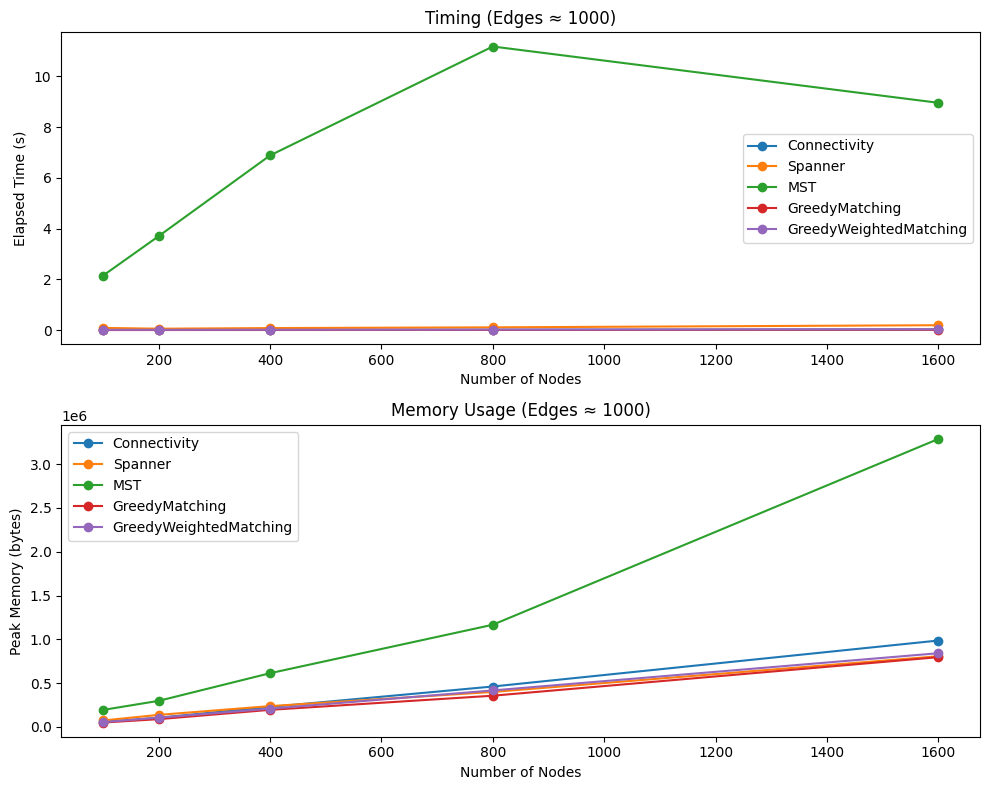

Creating sample graph G (n=1000, p=0.002002002002002002)...
Graph is not connected (162 components). Adding edges...
Added random weights to edges.
Sample graph created with 1000 nodes and 1160 edges.
Creating sample graph G (n=1000, p=0.004004004004004004)...
Graph is not connected (22 components). Adding edges...
Added random weights to edges.
Sample graph created with 1000 nodes and 2009 edges.
Creating sample graph G (n=1000, p=0.008008008008008008)...
Added random weights to edges.
Sample graph created with 1000 nodes and 4018 edges.
Creating sample graph G (n=1000, p=0.016016016016016016)...
Added random weights to edges.
Sample graph created with 1000 nodes and 7958 edges.
Creating sample graph G (n=1000, p=0.03203203203203203)...
Added random weights to edges.
Sample graph created with 1000 nodes and 15884 edges.


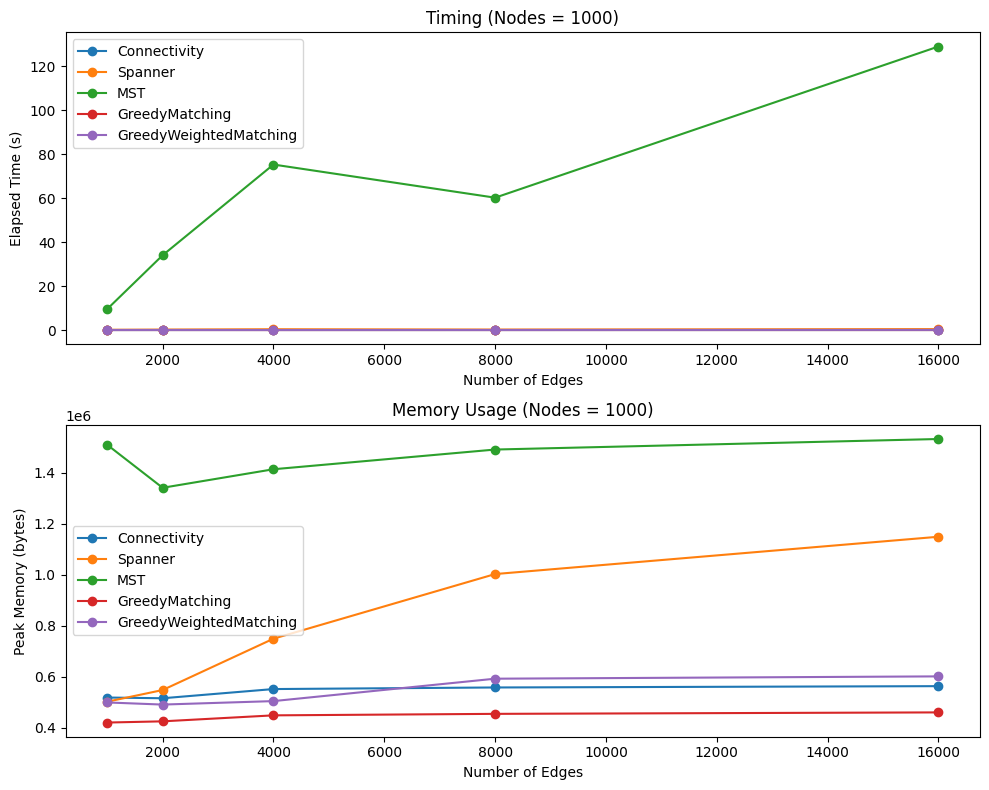

In [10]:
import networkx as nx
import time
import tracemalloc
import random
import matplotlib.pyplot as plt
from collections import defaultdict

# Assume the provided functions are imported or defined in this module
# from your_module import create_sample_graph, run_connectivity, run_spanner, run_mst,
#                                 run_greedy_matching, run_greedy_weighted_matching, measure_memory

# List of algorithms to benchmark
definitions = [
    ("Connectivity", run_connectivity, {}),
    ("Spanner", run_spanner, {"alpha": 3}),
    ("MST", run_mst, {}),
    ("GreedyMatching", run_greedy_matching, {}),
    ("GreedyWeightedMatching", run_greedy_weighted_matching, {"gamma": 0.1}),
]


def experiment_fixed_edges(m, nodes_list):
    """
    Keeps number of edges approximately constant at m, increases number of nodes.
    Returns dict of results for each algorithm.
    """
    results = {name: {'times': [], 'mems': []} for name, *_ in definitions}

    for n in nodes_list:
        # Compute p for expected m edges: m ~ p * (n*(n-1)/2)
        p = m / (n * (n - 1) / 2)
        G = create_sample_graph(n=n, p=p)
        stream = [(u, v, data) for u, v, data in G.edges(data=True)]

        for name, func, kwargs in definitions:
            _, elapsed, peak = measure_memory(func, stream, n, **kwargs)
            results[name]['times'].append(elapsed)
            results[name]['mems'].append(peak)

    return results


def experiment_fixed_nodes(n, edges_list):
    """
    Keeps number of nodes constant at n, increases number of edges.
    Returns dict of results for each algorithm.
    """
    results = {name: {'times': [], 'mems': []} for name, *_ in definitions}

    for m in edges_list:
        # Compute p for expected m edges on fixed n
        p = m / (n * (n - 1) / 2)
        G = create_sample_graph(n=n, p=p)
        stream = [(u, v, data) for u, v, data in G.edges(data=True)]

        for name, func, kwargs in definitions:
            _, elapsed, peak = measure_memory(func, stream, n, **kwargs)
            results[name]['times'].append(elapsed)
            results[name]['mems'].append(peak)

    return results


def plot_results(x_values, results, x_label, title_suffix):
    """
    Plots timing and memory consumption for each algorithm.
    """
    fig, axes = plt.subplots(2, 1, figsize=(10, 8))

    # Timing plot
    for name, data in results.items():
        axes[0].plot(x_values, data['times'], marker='o', label=name)
    axes[0].set_xlabel(x_label)
    axes[0].set_ylabel('Elapsed Time (s)')
    axes[0].set_title(f'Timing {title_suffix}')
    axes[0].legend()

    # Memory plot
    for name, data in results.items():
        axes[1].plot(x_values, data['mems'], marker='o', label=name)
    axes[1].set_xlabel(x_label)
    axes[1].set_ylabel('Peak Memory (bytes)')
    axes[1].set_title(f'Memory Usage {title_suffix}')
    axes[1].legend()

    plt.tight_layout()
    plt.show()


if __name__ == '__main__':
    # Experiment 1: fixed edges, varying nodes
    fixed_m = 1000
    node_sizes = [100, 200, 400, 800, 1600]
    results_nodes = experiment_fixed_edges(fixed_m, node_sizes)
    plot_results(node_sizes, results_nodes, 'Number of Nodes', f'(Edges ≈ {fixed_m})')

    # Experiment 2: fixed nodes, varying edges
    fixed_n = 1000
    edge_counts = [1000, 2000, 4000, 8000, 16000]
    results_edges = experiment_fixed_nodes(fixed_n, edge_counts)
    plot_results(edge_counts, results_edges, 'Number of Edges', f'(Nodes = {fixed_n})')


## Connectivity


In [11]:
import math
import random
from collections import defaultdict

# --- Disjoint Set Union (DSU) Implementation ---
# Standard DSU with path compression and union by size/rank
# Used to manage supernodes efficiently

class DSU:
    def __init__(self, n):
        # Initialize n sets, each containing one element (0 to n-1)
        self.parent = list(range(n))
        self.size = [1] * n
        self.num_sets = n

    def find(self, i):
        # Find the root of the set containing element i with path compression
        if self.parent[i] == i:
            return i
        # Path compression: point directly to the root
        self.parent[i] = self.find(self.parent[i])
        return self.parent[i]

    def union(self, i, j):
        # Merge the sets containing elements i and j using union by size
        root_i = self.find(i)
        root_j = self.find(j)
        if root_i != root_j:
            # Union by size: attach smaller tree to larger tree
            if self.size[root_i] < self.size[root_j]:
                root_i, root_j = root_j, root_i # Ensure root_i is larger root
            self.parent[root_j] = root_i
            self.size[root_i] += self.size[root_j]
            self.num_sets -= 1
            return True # Union performed
        return False # Already in the same set

    def get_num_components(self):
        return self.num_sets

    def get_supernodes(self):
        # Returns a dictionary mapping root -> list of nodes in the supernode
        supernodes = defaultdict(list)
        for i in range(len(self.parent)):
            root = self.find(i)
            supernodes[root].append(i)
        return dict(supernodes)

# --- Connectivity Algorithm Implementation ---

class ConnectivitySketch:
    def __init__(self, n, edges):
        """
        Initializes the connectivity algorithm simulator.

        Args:
            n (int): Number of nodes (labeled 0 to n-1).
            edges (list): List of tuples representing edges, e.g., [(0, 1), (1, 2)].
                          Assumes undirected edges, duplicates/order ignored.
        """
        if n <= 0:
             raise ValueError("Number of nodes must be positive.")
        self.n = n
        self.edges = set(tuple(sorted(edge)) for edge in edges if edge[0] < n and edge[1] < n and edge[0] != edge[1])

        # 1. Establish mapping between edges and indices (0 to m-1)
        self.m = 0
        self.edge_to_index = {}
        self.index_to_edge = {}
        potential_edges = sorted([(i, j) for i in range(n) for j in range(i + 1, n)])
        for idx, edge in enumerate(potential_edges):
             # Only map actual edges present in the input graph for efficiency
             # Correction: The a_i vectors are defined over *all* potential (n choose 2) edges.
             # We need the full mapping.
            self.edge_to_index[edge] = idx
            self.index_to_edge[idx] = edge
        self.m = len(self.edge_to_index) # Number of potential edges (n choose 2)

        # 2. Precompute the 'a_i' vectors (using sparse representation)
        self._build_a_vectors()

        # 3. Determine number of stages 't' = O(log n)
        # Using ceil(log2(n)) usually suffices, maybe add a small constant factor
        self.t = 1 if n <= 1 else (2 * math.ceil(math.log2(n)))

        # DSU structure for tracking components during simulation
        self.dsu = DSU(self.n)
        self._stages_run = False


    def _get_edge_index(self, u, v):
        """Helper to get the canonical index for edge {u, v}."""
        if u > v:
            u, v = v, u
        return self.edge_to_index.get((u, v), -1) # Return -1 if edge doesn't exist (shouldn't happen with full mapping)

    def _build_a_vectors(self):
        """
        Constructs the sparse representation of vectors a_i for each node i.
        a_i[edge_idx] = +1 if edge is {i, k} with i < k
        a_i[edge_idx] = -1 if edge is {j, i} with j < i
        a_i[edge_idx] = 0 otherwise
        Stores as dictionary: {edge_index: value}
        """
        self.a_vectors = [defaultdict(int) for _ in range(self.n)]
        for u, v in self.edges:
            # Ensure u < v for consistent indexing
            if u > v:
                u, v = v, u
            
            edge_idx = self.edge_to_index.get((u, v))
            if edge_idx is not None:
                # For node u: edge is {u, v} with u < v => +1
                self.a_vectors[u][edge_idx] = 1
                # For node v: edge is {u, v} with u < v => -1
                self.a_vectors[v][edge_idx] = -1

    def _run_stages(self):
        """
        Simulates the O(log n) stages of the connectivity algorithm using
        the precomputed a_i vectors and DSU for collapsing components.
        This function modifies self.dsu.
        """
        if self._stages_run: # Avoid re-running unnecessarily
            return

        # Reset DSU for a fresh run
        self.dsu = DSU(self.n)

        if self.n <= 1: # Trivial case
             self._stages_run = True
             return
             
        # --- Emulate the log n stages ---
        for stage in range(self.t):
            if self.dsu.get_num_components() <= 1:
                break # Already fully connected

            # Get current supernodes (components)
            current_supernodes = self.dsu.get_supernodes() # {root: [node1, node2...]}

            # --- Simulate Step 2b: Sample edges using sketches ---
            # In our simulation: Compute sum vectors for each supernode and sample
            
            edges_found_this_stage = []
            supernode_sum_vectors = defaultdict(lambda: defaultdict(int)) # root -> {edge_idx: sum_val}

            # Calculate sum vector for each supernode S: sum_{i in S} a_i
            for root, nodes_in_supernode in current_supernodes.items():
                current_sum_vector = supernode_sum_vectors[root] # Get ref to the dict
                for node_idx in nodes_in_supernode:
                    # Add the sparse a_vector of this node
                    for edge_idx, value in self.a_vectors[node_idx].items():
                        current_sum_vector[edge_idx] += value

            # Sample one edge outgoing from each supernode (if possible)
            sampled_edges_indices = set()
            for root, sum_vector in supernode_sum_vectors.items():
                # Find non-zero entries: these correspond to edges crossing the cut (S, V\S)
                cut_edge_indices = [idx for idx, val in sum_vector.items() if val != 0]

                if cut_edge_indices:
                    # Simulate l0-sampling: pick one random edge from the cut
                    sampled_edge_idx = random.choice(cut_edge_indices)
                    sampled_edges_indices.add(sampled_edge_idx)

            # Convert sampled indices back to edges {u, v}
            for edge_idx in sampled_edges_indices:
                 edge = self.index_to_edge.get(edge_idx)
                 if edge:
                     edges_found_this_stage.append(edge)

            # --- Collapse components based on sampled edges ---
            for u, v in edges_found_this_stage:
                self.dsu.union(u, v)

        self._stages_run = True


    def get_num_components(self):
        """
        Returns the number of connected components found by the algorithm.
        """
        self._run_stages() # Ensure the simulation has run
        return self.dsu.get_num_components()

    def is_connected(self):
        """
        Returns True if the graph is connected, False otherwise.
        """
        return self.get_num_components() == 1

# --- Bipartiteness Test Implementation ---

def is_bipartite(n, edges):
    """
    Tests if a graph is bipartite using the connectivity algorithm on the
    graph and its bipartite double cover.

    Args:
        n (int): Number of nodes in the original graph (0 to n-1).
        edges (list): List of edges [(u, v)] in the original graph.

    Returns:
        bool: True if the graph is bipartite, False otherwise.
        Returns True for graphs with 0 or 1 node.
    """
    if n <= 1:
        return True # Single node or empty graph is trivially bipartite

    # 1. Run connectivity on the original graph
    cs_orig = ConnectivitySketch(n, edges)
    num_components_orig = cs_orig.get_num_components()

    # 2. Construct the bipartite double cover graph
    n_double = 2 * n
    edges_double = []
    original_edges_set = set(tuple(sorted(edge)) for edge in edges if edge[0] < n and edge[1] < n and edge[0] != edge[1])

    for u, v in original_edges_set:
        # For edge {u, v} in G, add {u1, v2} and {u2, v1} in G'
        # Map u -> u (copy 1), u -> u + n (copy 2)
        # Map v -> v (copy 1), v -> v + n (copy 2)
        # Add edge {u_copy1, v_copy2} -> {u, v + n}
        edges_double.append((u, v + n))
        # Add edge {u_copy2, v_copy1} -> {u + n, v}
        edges_double.append((u + n, v))

    # 3. Run connectivity on the double cover
    cs_double = ConnectivitySketch(n_double, edges_double)
    num_components_double = cs_double.get_num_components()

    # 4. Check the condition
    # print(f"Original components: {num_components_orig}") # Debugging
    # print(f"Double cover components: {num_components_double}") # Debugging
    return num_components_double == (2 * num_components_orig)


# --- Example Usage ---

if __name__ == "__main__":
    # Example 1: Connected graph (Path graph)
    n1 = 5
    edges1 = [(0, 1), (1, 2), (2, 3), (3, 4)]
    print(f"--- Graph 1 (Path 0-1-2-3-4) ---")
    cs1 = ConnectivitySketch(n1, edges1)
    print(f"Nodes: {n1}, Edges: {edges1}")
    print(f"Is connected? {cs1.is_connected()}")          # Expected: True
    print(f"Number of components: {cs1.get_num_components()}") # Expected: 1
    print(f"Is bipartite? {is_bipartite(n1, edges1)}")    # Expected: True

    # Example 2: Disconnected graph (Two components)
    n2 = 6
    edges2 = [(0, 1), (1, 2), (3, 4)]
    print(f"\n--- Graph 2 (Components {0,1,2} and {3,4}, node 5 isolated) ---")
    cs2 = ConnectivitySketch(n2, edges2)
    print(f"Nodes: {n2}, Edges: {edges2}")
    print(f"Is connected? {cs2.is_connected()}")          # Expected: False
    print(f"Number of components: {cs2.get_num_components()}") # Expected: 3 (0-1-2, 3-4, 5)
    print(f"Is bipartite? {is_bipartite(n2, edges2)}")    # Expected: True (all components are bipartite)

    # Example 3: Connected, Non-bipartite graph (Triangle + tail)
    n3 = 4
    edges3 = [(0, 1), (1, 2), (2, 0), (2, 3)] # 0-1-2 form a triangle
    print(f"\n--- Graph 3 (Triangle 0-1-2 with tail 2-3) ---")
    cs3 = ConnectivitySketch(n3, edges3)
    print(f"Nodes: {n3}, Edges: {edges3}")
    print(f"Is connected? {cs3.is_connected()}")          # Expected: True
    print(f"Number of components: {cs3.get_num_components()}") # Expected: 1
    print(f"Is bipartite? {is_bipartite(n3, edges3)}")    # Expected: False

    # Example 4: Empty graph
    n4 = 3
    edges4 = []
    print(f"\n--- Graph 4 (Empty graph) ---")
    cs4 = ConnectivitySketch(n4, edges4)
    print(f"Nodes: {n4}, Edges: {edges4}")
    print(f"Is connected? {cs4.is_connected()}")          # Expected: False
    print(f"Number of components: {cs4.get_num_components()}") # Expected: 3
    print(f"Is bipartite? {is_bipartite(n4, edges4)}")    # Expected: True

    # Example 5: Single node graph
    n5 = 1
    edges5 = []
    print(f"\n--- Graph 5 (Single node) ---")
    cs5 = ConnectivitySketch(n5, edges5)
    print(f"Nodes: {n5}, Edges: {edges5}")
    print(f"Is connected? {cs5.is_connected()}")          # Expected: True
    print(f"Number of components: {cs5.get_num_components()}") # Expected: 1
    print(f"Is bipartite? {is_bipartite(n5, edges5)}")    # Expected: True

    # Example 6: Complete graph K4 (non-bipartite)
    n6 = 4
    edges6 = [(0,1), (0,2), (0,3), (1,2), (1,3), (2,3)]
    print(f"\n--- Graph 6 (Complete K4) ---")
    cs6 = ConnectivitySketch(n6, edges6)
    print(f"Nodes: {n6}, Edges: {edges6}")
    print(f"Is connected? {cs6.is_connected()}")          # Expected: True
    print(f"Number of components: {cs6.get_num_components()}") # Expected: 1
    print(f"Is bipartite? {is_bipartite(n6, edges6)}")    # Expected: False

--- Graph 1 (Path 0-1-2-3-4) ---
Nodes: 5, Edges: [(0, 1), (1, 2), (2, 3), (3, 4)]
Is connected? True
Number of components: 1
Is bipartite? True

--- Graph 2 (Components (0, 1, 2) and (3, 4), node 5 isolated) ---
Nodes: 6, Edges: [(0, 1), (1, 2), (3, 4)]
Is connected? False
Number of components: 3
Is bipartite? True

--- Graph 3 (Triangle 0-1-2 with tail 2-3) ---
Nodes: 4, Edges: [(0, 1), (1, 2), (2, 0), (2, 3)]
Is connected? True
Number of components: 1
Is bipartite? False

--- Graph 4 (Empty graph) ---
Nodes: 3, Edges: []
Is connected? False
Number of components: 3
Is bipartite? True

--- Graph 5 (Single node) ---
Nodes: 1, Edges: []
Is connected? True
Number of components: 1
Is bipartite? True

--- Graph 6 (Complete K4) ---
Nodes: 4, Edges: [(0, 1), (0, 2), (0, 3), (1, 2), (1, 3), (2, 3)]
Is connected? True
Number of components: 1
Is bipartite? False


Creating sample graph G (n=100, p=0.20202020202020202)...
Added random weights to edges.
Sample graph created with 100 nodes and 986 edges.
Creating sample graph G (n=200, p=0.05025125628140704)...
Added random weights to edges.
Sample graph created with 200 nodes and 949 edges.
Creating sample graph G (n=400, p=0.012531328320802004)...
Graph is not connected (4 components). Adding edges...
Added random weights to edges.
Sample graph created with 400 nodes and 1000 edges.
Creating sample graph G (n=800, p=0.0031289111389236545)...
Graph is not connected (77 components). Adding edges...
Added random weights to edges.
Sample graph created with 800 nodes and 1070 edges.
Creating sample graph G (n=1600, p=0.0007817385866166354)...
Graph is not connected (635 components). Adding edges...
Added random weights to edges.
Sample graph created with 1600 nodes and 1608 edges.


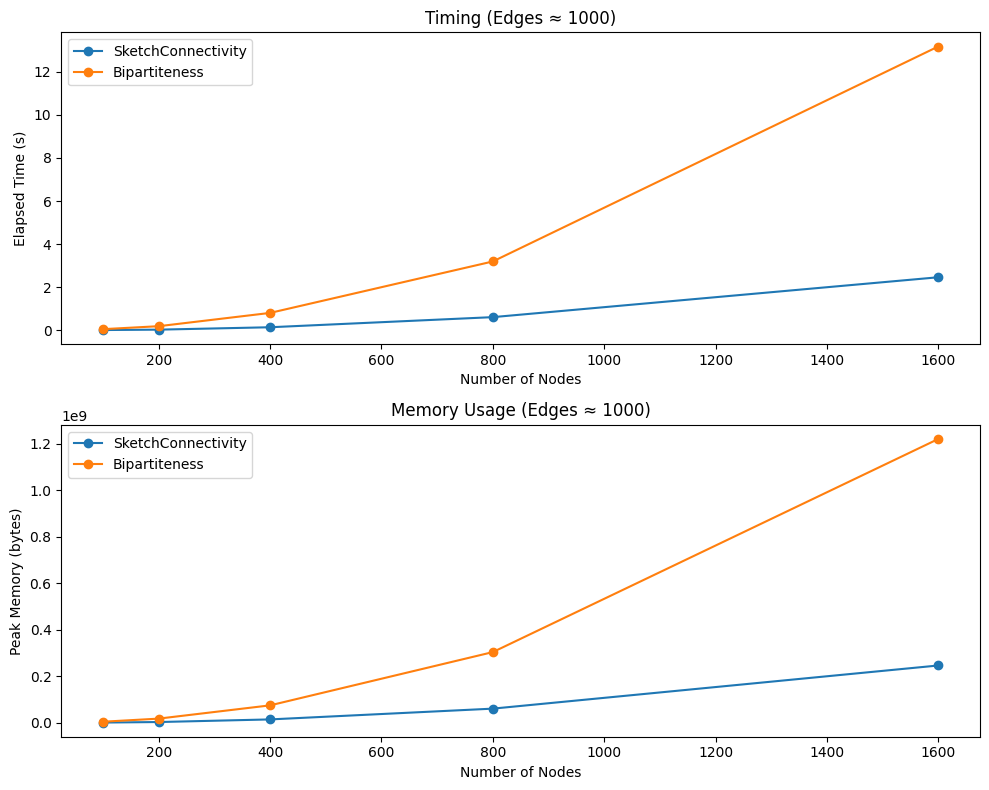

Creating sample graph G (n=1000, p=0.002002002002002002)...
Graph is not connected (162 components). Adding edges...
Added random weights to edges.
Sample graph created with 1000 nodes and 1160 edges.
Creating sample graph G (n=1000, p=0.004004004004004004)...
Graph is not connected (22 components). Adding edges...
Added random weights to edges.
Sample graph created with 1000 nodes and 2009 edges.
Creating sample graph G (n=1000, p=0.008008008008008008)...
Added random weights to edges.
Sample graph created with 1000 nodes and 4018 edges.
Creating sample graph G (n=1000, p=0.016016016016016016)...
Added random weights to edges.
Sample graph created with 1000 nodes and 7958 edges.
Creating sample graph G (n=1000, p=0.03203203203203203)...
Added random weights to edges.
Sample graph created with 1000 nodes and 15884 edges.


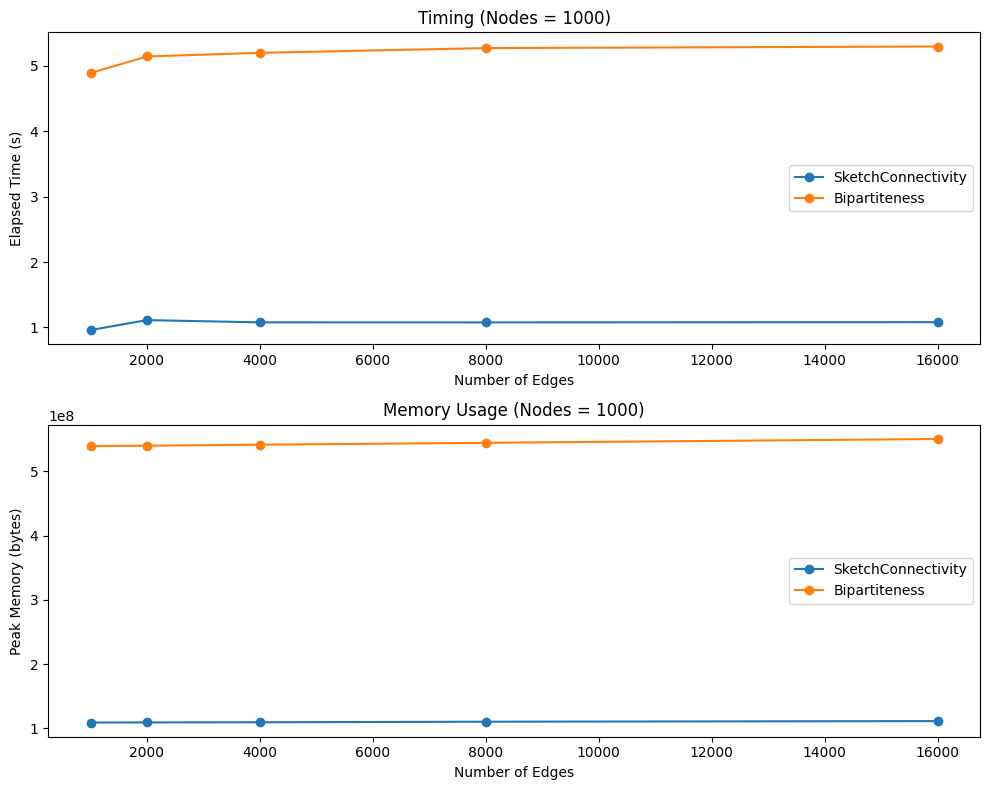

In [12]:
import networkx as nx
import time
import tracemalloc
import random
import matplotlib.pyplot as plt
from collections import defaultdict

# --- Existing graph algorithms ---
# Assume the provided functions are imported or defined in this module:
# create_sample_graph, run_connectivity, run_spanner, run_mst,
# run_greedy_matching, run_greedy_weighted_matching, measure_memory

# --- New Connectivity Sketch and Bipartiteness Test ---

# Wrapper for ConnectivitySketch
def run_connectivity_sketch(stream, n):
    """
    Runs the ConnectivitySketch algorithm to count components.
    """
    edges = [(u, v) for u, v, _ in stream]
    cs = ConnectivitySketch(n, edges)
    # Return number of components (result) for consistency
    return cs.get_num_components()

# Wrapper for Bipartiteness Test
def run_bipartiteness_test(stream, n):
    """
    Runs the bipartiteness test returning True/False.
    """
    edges = [(u, v) for u, v, _ in stream]
    return is_bipartite(n, edges)

# List of algorithms to benchmark
# Existing five plus two new ones
definitions = [
    # ("Connectivity", run_connectivity, {}),
    # ("Spanner", run_spanner, {"alpha": 3}),
    # ("MST", run_mst, {}),
    # ("GreedyMatching", run_greedy_matching, {}),
    # ("GreedyWeightedMatching", run_greedy_weighted_matching, {"gamma": 0.1}),
    ("SketchConnectivity", run_connectivity_sketch, {}),
    ("Bipartiteness", run_bipartiteness_test, {}),
]


def experiment_fixed_edges(m, nodes_list):
    """
    Keeps number of edges approximately constant at m, increases number of nodes.
    Returns dict of results for each algorithm.
    """
    results = {name: {'times': [], 'mems': []} for name, *_ in definitions}

    for n in nodes_list:
        # Compute p for expected m edges: m ~ p * (n*(n-1)/2)
        p = m / (n * (n - 1) / 2)
        G = create_sample_graph(n=n, p=p)
        stream = [(u, v, data) for u, v, data in G.edges(data=True)]

        for name, func, kwargs in definitions:
            _, elapsed, peak = measure_memory(func, stream, n, **kwargs)
            results[name]['times'].append(elapsed)
            results[name]['mems'].append(peak)

    return results


def experiment_fixed_nodes(n, edges_list):
    """
    Keeps number of nodes constant at n, increases number of edges.
    Returns dict of results for each algorithm.
    """
    results = {name: {'times': [], 'mems': []} for name, *_ in definitions}

    for m in edges_list:
        # Compute p for expected m edges on fixed n
        p = m / (n * (n - 1) / 2)
        G = create_sample_graph(n=n, p=p)
        stream = [(u, v, data) for u, v, data in G.edges(data=True)]

        for name, func, kwargs in definitions:
            _, elapsed, peak = measure_memory(func, stream, n, **kwargs)
            results[name]['times'].append(elapsed)
            results[name]['mems'].append(peak)

    return results


def plot_results(x_values, results, x_label, title_suffix):
    """
    Plots timing and memory consumption for each algorithm.
    """
    fig, axes = plt.subplots(2, 1, figsize=(10, 8))

    # Timing plot
    for name, data in results.items():
        axes[0].plot(x_values, data['times'], marker='o', label=name)
    axes[0].set_xlabel(x_label)
    axes[0].set_ylabel('Elapsed Time (s)')
    axes[0].set_title(f'Timing {title_suffix}')
    axes[0].legend()

    # Memory plot
    for name, data in results.items():
        axes[1].plot(x_values, data['mems'], marker='o', label=name)
    axes[1].set_xlabel(x_label)
    axes[1].set_ylabel('Peak Memory (bytes)')
    axes[1].set_title(f'Memory Usage {title_suffix}')
    axes[1].legend()

    plt.tight_layout()
    plt.show()


if __name__ == '__main__':
    # Experiment 1: fixed edges, varying nodes
    fixed_m = 1000
    node_sizes = [100, 200, 400, 800, 1600]
    results_nodes = experiment_fixed_edges(fixed_m, node_sizes)
    plot_results(node_sizes, results_nodes, 'Number of Nodes', f'(Edges ≈ {fixed_m})')

    # Experiment 2: fixed nodes, varying edges
    fixed_n = 1000
    edge_counts = [1000, 2000, 4000, 8000, 16000]
    results_edges = experiment_fixed_nodes(fixed_n, edge_counts)
    plot_results(edge_counts, results_edges, 'Number of Edges', f'(Nodes = {fixed_n})')


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx

def experiment_fixed_graphs(graphs, definitions, measure_memory):
    # allow passing in a single Graph or a list of them
    if isinstance(graphs, nx.Graph):
        graphs = [graphs]

    # initialize result containers
    results = { name: {'times': [], 'mems': []}
                for name, *_ in definitions }
    f_results = []

    for G in graphs:
        n = G.number_of_nodes()
        stream = [(u, v, data) for u, v, data in G.edges(data=True)]

        for name, func, kwargs in definitions:
            f_result, elapsed, peak = measure_memory(func, stream, n, **kwargs)
            f_results.append((name, f_result))
            results[name]['times'].append(elapsed)
            results[name]['mems'].append(peak)

    return results, f_results

# --- load your graph once (no randomness) ---
G = nx.read_edgelist(
    './dataset/twitch/DE/musae_DE_edges.csv',
    delimiter=',',
    nodetype=int,
    data=(('weight', float),)
)
G = nx.Graph(G)  # if you want to ensure undirected

definitions = [
    ("Connectivity",             run_connectivity,          {}),
    ("Spanner",                  run_spanner,               {"alpha": 3}),
    ("MST",                      run_mst,                   {}),
    ("GreedyMatching",           run_greedy_matching,       {}),
    ("GreedyWeightedMatching",   run_greedy_weighted_matching, {"gamma": 0.1}),
    ("SketchConnectivity",       run_connectivity_sketch,   {}),
    ("Bipartiteness",            run_bipartiteness_test,    {}),
]

# Pass *either* G or [G] here
results, f_results = experiment_fixed_graphs(G, definitions, measure_memory)

# Now print or tabulate
print("Timing results (in seconds):")
for name in results:
    print(f"  {name:25s} -> {results[name]['times']}")

print("\nMemory peaks (in MB):")
for name in results:
    print(f"  {name:25s} -> {results[name]['mems']}")

# Optional: build a DataFrame for nicer presentation/plotting
df_times = pd.DataFrame({ name: data['times'] 
                          for name, data in results.items() })
df_mems  = pd.DataFrame({ name: data['mems']  
                          for name, data in results.items() })

# display tables
print("\n=== DataFrame of times ===")
print(df_times)

print("\n=== DataFrame of memory peaks ===")
print(df_mems)

# Optional: simple plot of runtimes
df_times.plot(marker='o', figsize=(8,4))
plt.title("Algorithm runtimes on your graph")
plt.xlabel("Trial index")
plt.ylabel("Time (s)")
plt.tight_layout()
plt.show()
